# Writing Production Code

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Management
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# Date & Time
import datetime

# Random
import random

In [2]:
ORIGINAL_DATA = np.array((199.9, 207.2, 185.3, 312.7, 277.3, 373.5, 456.2, 
                   121.9, 155.3, 167.4, 222.1, 139.2, 157.8, 212.1, 
                   241.8, 277.2, 145.6, 192.2, 203.4, 166.5, 177.3, 193.1, 134.9, 199.9, 217.4))

BOUNDARY_DATA = np.array((155.1, 173.2, 183.9, 217.3, 224.9))

In [3]:
def na_replacements(data, mode):
    series = data.copy()
    valid_check = ~np.isnan(series)
    valid_indeces = valid_check.ravel().nonzero()[0]
    invalid_indeces = np.isnan(series).ravel().nonzero()[0]
    valid_values = series[valid_check]
    
    if mode == 'intr':
        series[np.isnan(series)] = np.interp(invalid_indeces, valid_indeces, valid_values)
    elif mode == 'zero':
        series[np.isnan(series)] = 0.0
    else:
        raise ValueError("Improper mode selected. Must be either 'intr' or 'zero'")
    return series

In [4]:
def generate_data(feature_array, boundary_array, replacements='zero', start_date="2021-04-07"):
    adjusted_features = [x * 0.82 for x in feature_array.copy()]
    np.random.shuffle(adjusted_features)
    nulls = np.array([np.nan] * feature_array.size)
    orig_features = np.append(np.append(feature_array, boundary_array), nulls)
    new_features = np.append(nulls, np.append(boundary_array, adjusted_features))
    dates = np.arange(np.datetime64(start_date), np.timedelta64(orig_features.size, 'D'))
    df = pd.DataFrame(np.array((dates, 
                                na_replacements(orig_features, replacements), 
                                na_replacements(new_features, replacements))).T,
                      columns=["date", "original_feature", "new_feature"]
                     )
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    df.set_index('date', inplace=True)
    df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
    
    return df

In [5]:
def plot_data(data, cutoff_size, boundary_size, image_name="whoops"):
    with plt.style.context(style='seaborn-v0_8'):
        fig, axes = plt.subplots(2, 1, figsize=(9, 9))
        plt.subplots_adjust(hspace=0.4)
        ax0 = data['original_feature'].plot(ax=axes[0], ls='-', c='royalblue', lw=3, 
                                        label='Bags of dog food sold per day')
        ax1 = data['new_feature'].plot(ax=axes[1], ls='-', c='forestgreen', lw=3, 
                                        label='Bags of dog food sold per day adjusted')
        axes[0].set_title("Historical data for dog food sales", fontsize=10)
        axes[1].set_title("New adjusted dog food sales", fontsize=10)
        axes[0].legend(loc='upper right')
        axes[1].legend(loc='upper left')
        axes[0].vlines(data.index[cutoff_size], 0, ORIGINAL_DATA.max(), color='darkorange', lw=4)
        axes[0].vlines(data.index[cutoff_size + boundary_size -1], 0, ORIGINAL_DATA.max(), color='r', lw=4)
        axes[1].vlines(data.index[cutoff_size], 0, ORIGINAL_DATA.max(), color='darkorange', lw=4)
        axes[1].vlines(data.index[cutoff_size + boundary_size -1], 0, ORIGINAL_DATA.max(), color='r', lw=4)
        axes[0].set_xlabel('Date', fontsize=10)
        axes[0].set_ylabel('Sales (in thousands)', fontsize=10)
        axes[1].set_xlabel('Date', fontsize=10)
        axes[1].set_ylabel('Sales (in thousands)', fontsize=10)
        plt.tight_layout()
        plt.savefig("{}.svg".format(image_name), format='svg')
        plt.show()

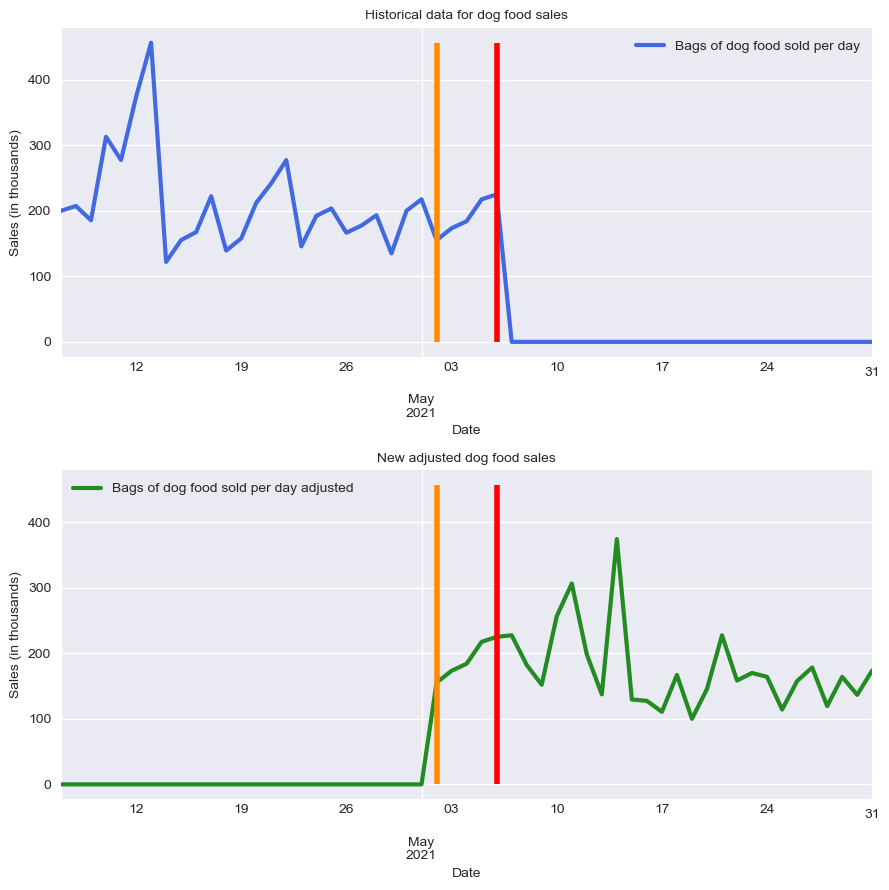

In [6]:
whoops = generate_data(ORIGINAL_DATA, BOUNDARY_DATA)
plot_data(whoops, ORIGINAL_DATA.size, BOUNDARY_DATA.size)

#### A Very Simple Feature Monitoring Script

In [7]:
prior_to_shift = np.append(ORIGINAL_DATA, BOUNDARY_DATA)

prior_stats = {}

prior_stats['prior_stddev'] = np.std(prior_to_shift)
prior_stats['prior_mean'] = np.mean(prior_to_shift)
prior_stats['prior_median'] = np.median(prior_to_shift)
prior_stats['prior_min'] = np.min(prior_to_shift)
prior_stats['prior_max'] = np.max(prior_to_shift)

In [8]:
prior_stats

{'prior_stddev': 70.23796409350146,
 'prior_mean': 209.71999999999994,
 'prior_median': 196.5,
 'prior_min': 121.9,
 'prior_max': 456.2}

In [9]:
post_shift = np.append(BOUNDARY_DATA, np.full(ORIGINAL_DATA.size, 0))

post_stats = {}

post_stats['post_stddev'] = np.std(post_shift)
post_stats['post_mean'] = np.mean(post_shift)
post_stats['post_median'] = np.median(post_shift)
post_stats['post_min'] = np.min(post_shift)
post_stats['post_max'] = np.max(post_shift)

In [10]:
post_stats

{'post_stddev': 71.95139902894329,
 'post_mean': 31.813333333333333,
 'post_median': 0.0,
 'post_min': 0.0,
 'post_max': 224.9}

In [11]:
bad_things = "Bad things are afoot in our sales data!"

if post_stats['post_mean'] <= prior_stats['prior_min']: print(bad_things + " Mean is lower than training min!")
if post_stats['post_mean'] >= prior_stats['prior_max']: print(bad_things + " Mean is higher than training max!")
if ~(prior_stats['prior_stddev'] * 0.5  <= post_stats['post_stddev'] <=  2. *prior_stats['prior_stddev']): 
    print(bad_things + " stddev is way out of bounds!")

Bad things are afoot in our sales data! Mean is lower than training min!


#### Timing Trials

In [12]:
time_spent = {'meetings': 0.2,
              'monitoring': 0.15,
              'troubleshooting': 0.5,
              'project_work': 0.1,
              'research': 0.05
             }

time = pd.DataFrame(time_spent, index=[0]).T.reset_index()
time.columns = ['activity', 'time_percentage']
error = np.random.rand(len(time)) / 50

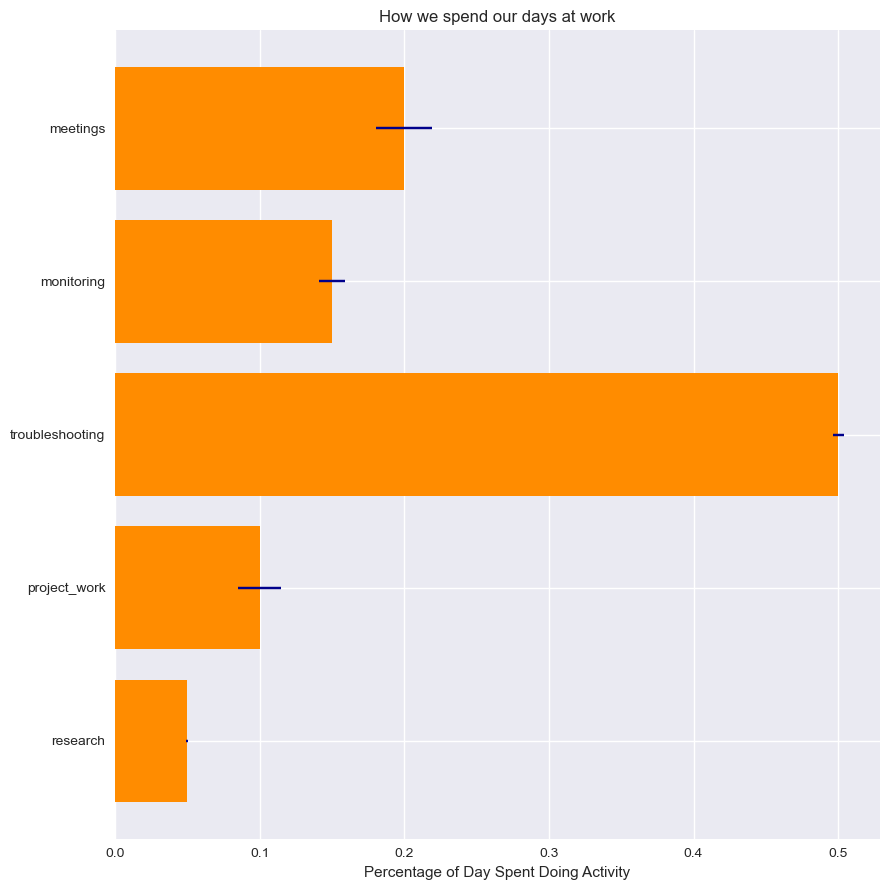

In [15]:
with plt.style.context(style='seaborn-v0_8'):
    fig, axes = plt.subplots(1, 1, figsize=(9, 9))
    axes.barh(np.arange(len(time)), time['time_percentage'], xerr=error, color='darkorange', ecolor='darkblue')
    axes.set_yticks(np.arange(len(time)))
    axes.set_yticklabels(time['activity'])
    axes.invert_yaxis()
    axes.set_xlabel("Percentage of Day Spent Doing Activity")
    axes.set_title("How we spend our days at work")
    plt.tight_layout()
    plt.savefig("worktime.svg", format='svg')
    plt.show()

#### Data "As & After" Training

In [16]:
data_as_of_training = np.random.normal(loc=185.3, scale=15.0, size=10000)
data_after_training = np.random.normal(loc=125.7, scale=12.0, size=10000)

training_days = np.arange(np.datetime64("2021-01-01"), np.datetime64("2021-01-08"), np.timedelta64(1, 'm') )[:10000]
after_training_days = np.arange(training_days[-1], np.datetime64("2021-01-15"), np.timedelta64(1, 'm') )[:10000]

x_jitter_training = [random.uniform(0.85, 1.15) * x for x in np.full(10000,1)]
x_jitter_after = [random.uniform(1.85, 2.15) * x for x in np.full(10000,1)]

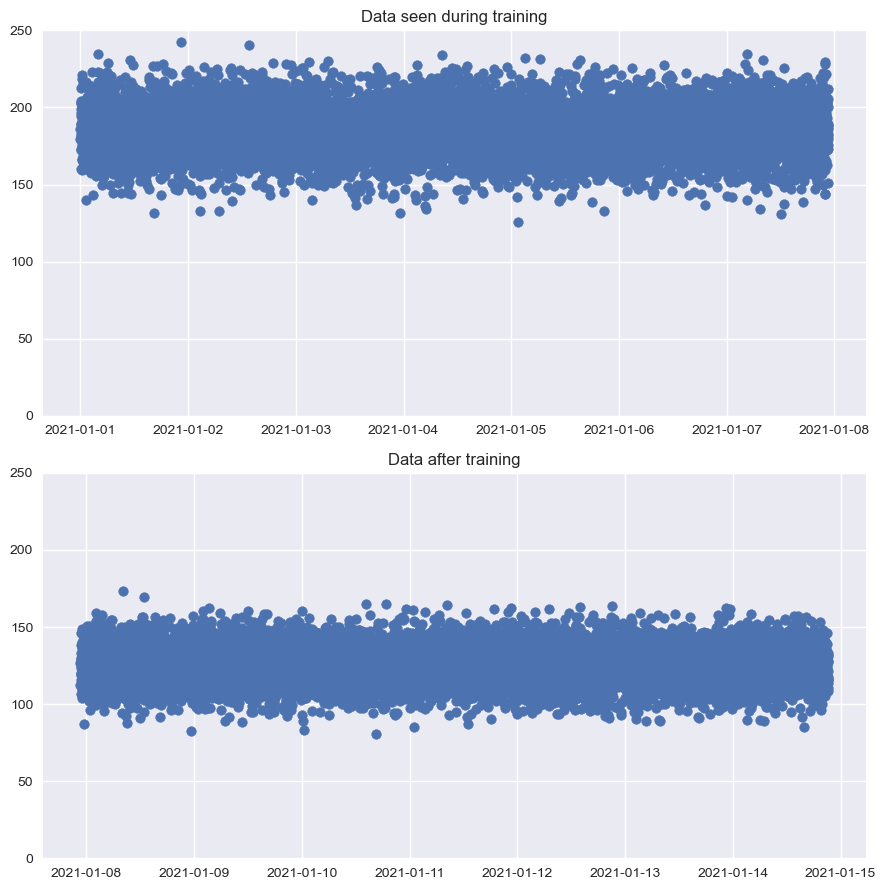

In [19]:
with plt.style.context(style='seaborn-v0_8'):
    fig, axes = plt.subplots(2, 1, figsize=(9,9))
    axes[0].scatter(training_days, data_as_of_training)
    axes[0].set_title("Data seen during training")
    axes[1].scatter(after_training_days, data_after_training)
    axes[1].set_title("Data after training")
    for ax in axes:
        ax.set_ylim([0, 250])
    plt.tight_layout()
    plt.savefig("chronolgoical_shift.svg", format='svg')
    plt.show()

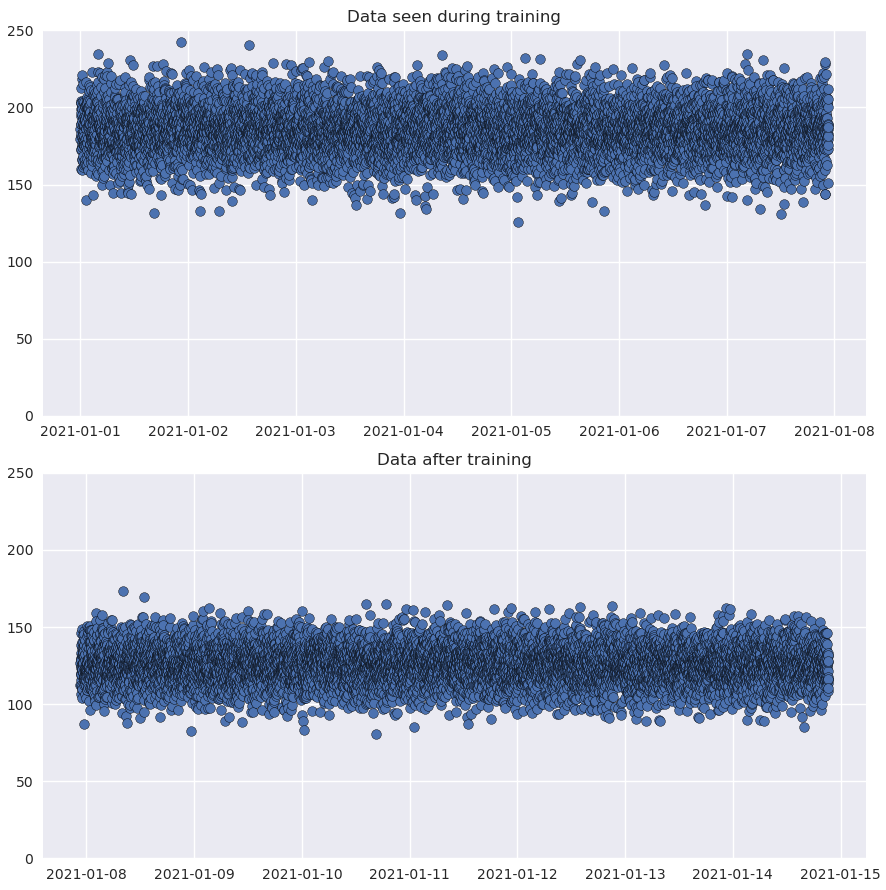

In [20]:
with plt.style.context('seaborn-v0_8'):
    fig, axes = plt.subplots(2, 1, figsize=(9, 9))
    axes[0].scatter(training_days, data_as_of_training, edgecolor='black')
    axes[0].set_title("Data seen during training")
    axes[1].scatter(after_training_days, data_after_training, edgecolor='black')
    axes[1].set_title("Data after training")
    for ax in axes:
        ax.set_ylim([0, 250])
    plt.tight_layout()
    plt.savefig("chronological_shift.svg", format='svg')

plt.show()

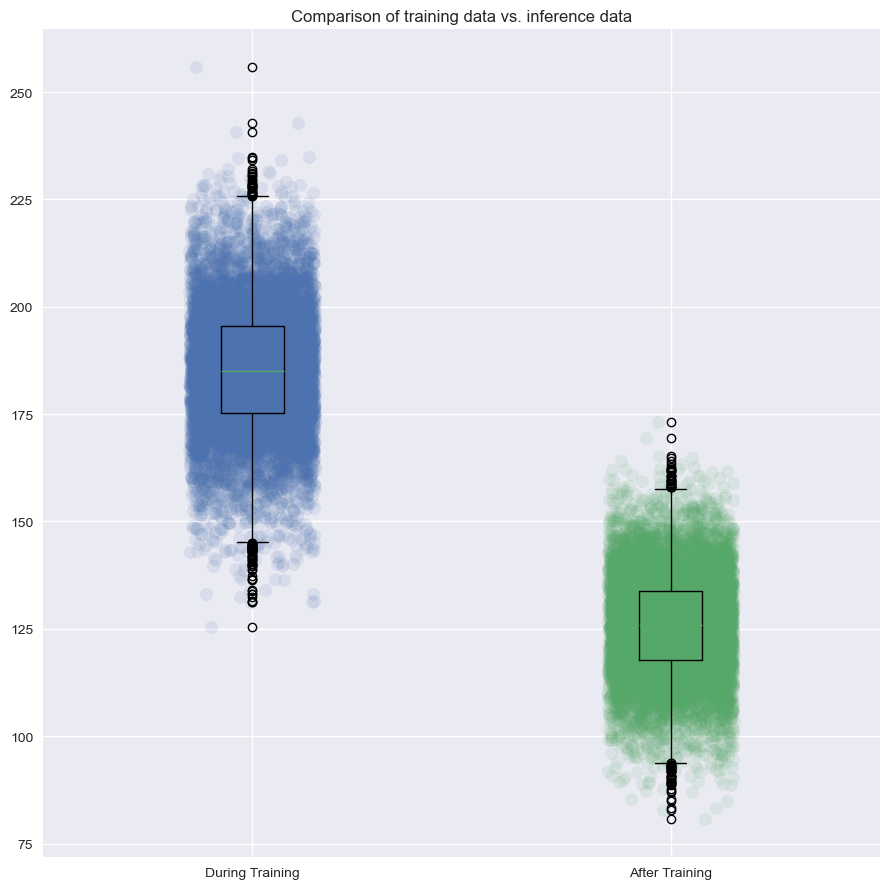

In [21]:
with plt.style.context(style='seaborn-v0_8'):
    fig, ax = plt.subplots(1,1, figsize=(9,9))
    ax.boxplot([data_as_of_training, data_after_training])
    ax.scatter(x_jitter_training, data_as_of_training, marker='o', s=80, alpha=0.1)
    ax.set_xticklabels(['During Training', 'After Training'])
    ax.scatter(x_jitter_after, data_after_training, marker='o', s=80, alpha=0.1)
    ax.set_title("Comparison of training data vs. inference data")
    plt.tight_layout()
    plt.savefig("boxplot_shift.svg", format='svg')
    plt.show()